## Partial Least Squares (PLS) analysis of cognitive measures with health, demographic and pollution features

This notebook provides a PLS analysis of LASI-DAD dataset by viewing it as two datasets: a cognitive dataset, and a health, demographics and pollution dataset. We used a small subset of the features (identified as important features in other analysis') from the whole dataset to provide an easy to interpret analysis. Our aim is to find associations between these two datasets which link to disease severity and provide an analysis of feature importance in this associative effect.

### Introduction to PLS

PLS is a multi-view statistical method that finds pairs of weight vectors/components (wx and wy) with maximum covariation between datasets. These weight vectors can be directly interpreted as feature importance and give us an idea of which features contribute to an associative effect.

### Import libraries

In [2]:
import pandas as pd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from scipy.linalg import svd
from collections import OrderedDict
import random
from statsmodels.discrete.discrete_model import Logit
import statsmodels as sm
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

### Import and format data

In [6]:
path = './LASIDAD'
X_features = [
'r1agey','ragender','raedyrs','h1rural','r1obsnoise','r1obsodor','r1obsair','r1obshouse','r1i_hear','r1i_sleep','r1systo','r1diasto',
'r1pulse','r1bphigh','r1mheight','r1mweight','r1mbmi','r1bmicat','r1adla_d','r1cesd10','r1anx5','r1mna_scale','r1hear_r',
'r1hear_l','r1hear_aid',
]

Y_features = [
'r1borient','r1bexefu','r1blangf','r1bmemory','r1bvsp','r1nmemimm','r1nmemdel','r1nmemrec','r1nreason','r1natnspd','r1sgcp','r1hmse_scorz','r1word_totaz',
'r1word_dz','r1wre_scorez','r1log_recoz','r1bm_immexz','r1bm_reclexz','r1verbalz','r1csid_scorz','r1cog_totalz','r1rv_scorez',
]

X_features = X_features + ['prim_key']
Y_features = Y_features + ['prim_key']

data =  pd.read_csv(join(path, 'categorical_data.csv'), index_col=0)
data_cont =  pd.read_csv(join(path, 'continuous_data.csv'), index_col=0)
data = pd.merge(data, data_cont, left_on='prim_key', right_on='prim_key')

#data_X: demographics, health and pollution measures
data_X = data[X_features]

#data_Y: cognitive measures
data_Y = data[Y_features]

#define clinical features
data_clin = pd.read_csv(join(path, 'data_clinical.csv'), index_col=0)
data_clin = data_clin[data_clin['r1cdr_final'].notna()]
score = data_clin['r1cdr_final']

#only keep data with clinical labels
data_X = data_X.loc[data_X['prim_key'].isin(data_clin['prim_key'])]

#drop X features that don't have at least 15 filled columns
data_X = data_X.dropna(axis=0, thresh=15)
data_X = data_X.fillna(0)

#match up subjs across datasets
data_Y = data_Y.loc[data_Y['prim_key'].isin(data_clin['prim_key'])]
data_Y = data_Y.loc[data_Y['prim_key'].isin(data_X['prim_key'])]
data_clin = data_clin.loc[data_clin['prim_key'].isin(data_Y['prim_key'])]
score = data_clin['r1cdr_final']

#drop subj key
data_X.drop(['prim_key'], axis=1, inplace=True)
data_Y.drop(['prim_key'], axis=1, inplace=True)

#format labels
labels_file = pd.read_csv(join(path, 'labels_mapping.csv'))
labels_file['Identifier'] = labels_file['Identifier'].apply(lambda x: x.lower())
labels_file['Description'] = labels_file['Description'].str.replace('r_', '')
labels_file['Description'] = labels_file['Description'].str.replace('R_', '')
labels_file['Description'] = labels_file['Description'].str.replace('_', ' ')

In [7]:
data_X.head()

,r1agey,ragender,raedyrs,h1rural,r1obsnoise,r1obsodor,r1obsair,r1obshouse,r1i_hear,r1i_sleep,...,r1mweight,r1mbmi,r1bmicat,r1adla_d,r1cesd10,r1anx5,r1mna_scale,r1hear_r,r1hear_l,r1hear_aid
0,-0.23,2,-0.82,1,0.00,0.00,0.00,0.00,0.77,1.35,...,0.66,0.96,1.01,-0.80,0.56,0.38,1.20,0.13,0.79,-0.08
1,-0.09,2,-0.82,1,0.00,0.00,0.00,0.00,-0.93,1.35,...,-1.19,0.00,0.00,-0.80,0.74,-0.23,0.00,-0.65,0.79,-0.08
2,-1.15,1,1.32,1,0.00,0.00,0.00,0.00,0.77,0.32,...,-0.20,-0.37,-0.16,2.49,1.49,0.08,-1.37,1.71,1.56,-0.08
4,-0.09,1,0.89,1,0.00,0.00,0.00,0.00,1.62,-1.74,...,0.15,-0.46,-0.16,-0.80,0.74,-0.85,-0.37,0.92,0.02,-0.08
5,-0.62,1,2.82,1,0.00,0.00,0.00,0.00,-0.93,-0.71,...,0.00,0.00,0.00,-0.80,-1.48,-0.54,0.00,1.71,1.56,-0.08


In [8]:
data_Y.head()

,r1borient,r1bexefu,r1blangf,r1bmemory,r1bvsp,r1nmemimm,r1nmemdel,r1nmemrec,r1nreason,r1natnspd,...,r1word_totaz,r1word_dz,r1wre_scorez,r1log_recoz,r1bm_immexz,r1bm_reclexz,r1verbalz,r1csid_scorz,r1cog_totalz,r1rv_scorez
0,1.21,-1.01,0.15,-0.63,-1.91,-0.16,-0.45,-1.06,-1.38,-0.58,...,-0.10,0.40,-1.68,-2.38,-0.05,-0.74,1.90,0.69,-0.35,-0.45
1,-2.20,-1.61,-1.65,-1.39,-0.88,-1.78,-1.38,0.37,-1.60,-1.29,...,-1.27,-1.33,-1.68,-0.15,-1.28,-0.74,-2.48,-0.53,-1.89,-1.05
2,1.21,-0.14,0.56,0.07,1.07,0.64,-0.42,0.53,-0.84,0.47,...,1.08,-0.03,0.84,0.49,-0.05,-0.74,1.68,-0.53,0.50,-0.15
4,1.21,1.54,1.24,0.56,1.18,1.00,-0.03,0.12,1.05,1.93,...,0.88,-0.47,0.84,-0.15,1.80,1.75,1.02,0.69,1.06,0.16
5,1.21,1.56,1.43,1.16,1.88,1.37,1.01,0.99,0.93,2.08,...,1.47,1.26,0.84,0.81,1.80,2.37,1.68,0.69,1.83,0.46


In [9]:
labels_file.head()

,Identifier,Description
0,r1agey,age
1,ragender,gender
2,raedyrs,years of education
3,h1rural,rural or urban
4,r1obsnoise,noise at home


### Split data into training and test sets

As well as using the PLS components for analysis purposes, we can see how well they generalise to unseen data by projecting the components learnt on a training set onto a test set.

In [10]:
random.seed(42)
train_idx = list(random.sample(range(0, np.shape(data_X)[0]), int(np.shape(data_X)[0]*0.8)))
test_idx = np.setdiff1d(list(range(np.shape(data_X)[0])),train_idx)

data_X_train = data_X.iloc[train_idx,:]
data_Y_train = data_Y.iloc[train_idx,:]
data_X_test = data_X.iloc[test_idx,:]
data_Y_test = data_Y.iloc[test_idx,:]
score_train = score.iloc[train_idx]
score_test = score.iloc[test_idx]

### PLS

Generate the set of PLS components ordered by decreasing covariance

In [11]:
U, _, VT = svd(np.dot(np.transpose(data_X_train),data_Y_train), full_matrices=False)
wx = U
wy = np.transpose(VT)

### PLS projections

Project the first PLS components calculated on the training data onto the test set

In [13]:
proj_X = np.dot(data_X_test,wx[:,0])
proj_Y = np.dot(data_Y_test,wy[:,0])
corr = np.corrcoef(proj_X,proj_Y)
abs_corr = np.absolute(corr[0,1])
print(abs_corr)

0.6619047265625964


Strong correlation between the two projections suggesting that there is significant association between the two datasets

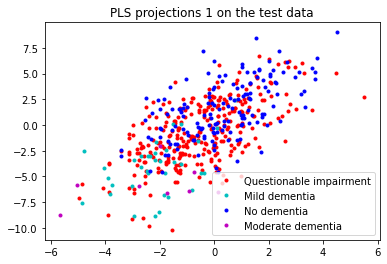

In [16]:
score_test_bins = pd.cut(score_test, [-0.1, 0.49, 0.99, 1.9, 2.9, 10], labels=False)
target = score_test_bins
label_list = ['No dementia', 'Questionable impairment', 'Mild dementia', 'Moderate dementia', 'Severe dementia']
color_code = ['b','r','c','m','y','g','k']
plt.figure()
for j in target.unique():
    plt.plot(proj_X[np.where(target==j)],proj_Y[np.where(target==j)], color=color_code[j], label = label_list[j], linestyle='None', marker = '.')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('PLS projections 1 on the test data')
plt.show()

The first set of PLS projections shows some stratification by disease severity suggesting that the strongest association between the two datasets is in part driven by disease effects

### PLS weights plots

Plot the PLS weights for the first associative effect

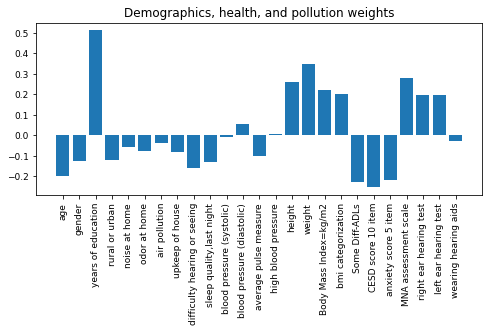

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
columns = list(labels_file[labels_file['Identifier'].isin(data_X.columns)]['Description'].values)
values = wx[:,0]
ax.bar(columns,values)
plt.title('Demographics, health, and pollution weights')
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=9)
fig.subplots_adjust(bottom=0.4)
plt.show()

Number of years of education contributes the most to the first associative effect. The weights of years in education and age are in opposite directions - years in education contributes positively to the associative effect (which stratifies subjects by decreased disease severity) and age contributes negatively to the associative effect

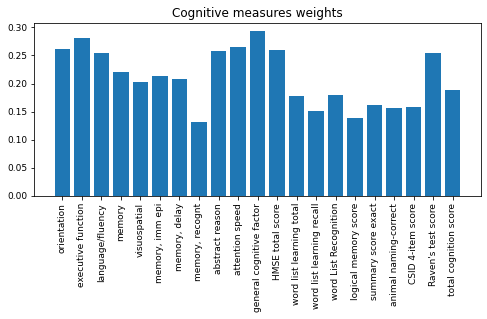

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
columns = list(labels_file[labels_file['Identifier'].isin(data_Y.columns)]['Description'].values)
values = wy[:,0]
ax.bar(columns,values)
plt.title('Cognitive measures weights')
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=9)
fig.subplots_adjust(bottom=0.4)
plt.show()

All cognitive measures contribute positively to the associative effect